In [ ]:
import re
import os
import numpy as np
from progress.bar import Bar
from tqdm import tqdm
import time

In [13]:

def writeRadius(r1,r2):
    lpMesh = open("loop.geo", "r")
    loopMesh = lpMesh.read()
    lpMesh.close()

    reg1 = r"(%r1)"
    reg2 = r"(%r2)"

    sub1 = str(r1)
    sub2 = str(r2)

    loopMesh = re.sub(reg1,sub1,loopMesh,0,re.MULTILINE)
    loopMesh = re.sub(reg2,sub2,loopMesh,0,re.MULTILINE)

    try:
        lpTemp = open("loopTemp.geo", "x")
    except:
        os.remove("loopTemp.geo")
        lpTemp = open("loopTemp.geo","x")

    lpTemp.write(loopMesh)
    lpTemp.close()


    # write surface mesh
    lpMesh = open("loopFIELD.geo", "r")
    loopMesh = lpMesh.read()
    lpMesh.close()
    reg1 = r"(%r1)"
    reg2 = r"(%r2)"
    sub1 = str(r1)
    sub2 = str(r2)
    loopMesh = re.sub(reg1,sub1,loopMesh,0,re.MULTILINE)
    loopMesh = re.sub(reg2,sub2,loopMesh,0,re.MULTILINE)
    try:
        lpTemp = open("loopFIELDTemp.geo", "x")
    except:
        os.remove("loopFIELDTemp.geo")
        lpTemp = open("loopFIELDTemp.geo","x")
    lpTemp.write(loopMesh)
    lpTemp.close()

def runGMSH():
    print(f"{os.getpid()}: Meshing geometry\n")
    # os.system("gmsh loopFIELDTemp.geo -nopopup -0 -v 1")
    # os.system("gmsh loopTemp.geo -nopopup -0 -v 1")
    os.popen("gmsh loopFIELDTemp.geo -nopopup -0 -v 1").read()
    os.popen("gmsh loopTemp.geo -nopopup -0 -v 1").read()
    try:
        os.system("rm *.geo_unrolled")
        os.remove("loopFIELDTemp.geo")
        os.remove("loopTemp.geo")
    except:
        print("nope")
    print(f"{os.getpid()}: Done meshing\n")


def runTTH():
    print(f"{os.getpid()}: Running tth settings_washer.json >/dev/null 2>&1")
    os.system("tth settings_washer.json >/dev/null 2>&1")
    print(f"{os.getpid()}: Done\n")


def getCurrent():
    iFile = open("./output/i.txt")
    it = iFile.read()
    iFile.close()
    reg = r"fone fone .+ (\d*\.\d*e.\d*)"
    i_s = re.findall(reg,it,re.MULTILINE)[0]
    return i_s
    
def runNoiseEx(b_path,current):
    path = "/home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex"
    print(f"{os.getpid()}: Running "+path+" "+b_path+" "+current)
    v = os.popen(path+" "+b_path+" "+current).read()
    print(f"{os.getpid()}: Done\n")
    v = v.split("\n")
    return v

def getElementsAndNodeCount():
    iFile = open("./loop.msh")
    it = iFile.read()
    iFile.close()
    regNumNodes = r"\$Nodes\n(.*)\n"
    numNodes = re.findall(regNumNodes,it,re.MULTILINE)[0]
    regNumElem = r"\$Elements\n(.*)\n"
    numElem = re.findall(regNumElem,it,re.MULTILINE)[0]

    return numElem, numNodes

def writeTargetElem(c):
    lpMesh = open("loop.geo", "r")
    loopMesh = lpMesh.read()
    lpMesh.close()
    reg1 = r"(%c)"
    sub1 = str(c)
    loopMesh = re.sub(reg1,sub1,loopMesh,0,re.MULTILINE)
    try:
        lpTemp = open("loopTemp.geo", "x")
    except:
        os.remove("loopTemp.geo")
        lpTemp = open("loopTemp.geo","x")
    lpTemp.write(loopMesh)
    lpTemp.close()
    
    # write surface mesh
    lpMesh = open("loopFIELD.geo", "r")
    loopMesh = lpMesh.read()
    lpMesh.close()
    reg1 = r"(%c)"
    sub1 = str(c)
    loopMesh = re.sub(reg1,sub1,loopMesh,0,re.MULTILINE)
    try:
        lpTemp = open("loopFIELDTemp.geo", "x")
    except:
        os.remove("loopFIELDTemp.geo")
        lpTemp = open("loopFIELDTemp.geo","x")
    lpTemp.write(loopMesh)
    lpTemp.close()    



### Triangles:

In [15]:


SPIN_DENS = 5e17
MU_B = 9.2740100783e-24
PHI_0 = 2.067833848e-15
MU_0 = 1.25663706212e-6 	
Analytic = lambda R, D : 2/3*MU_0**2*MU_B**2*SPIN_DENS*R/D*1/(PHI_0**2)

cl = np.arange(4,15)
r1 = 15e-6
r2 = 0.2e-6

try:
    os.remove("triangles.csv")
except:
    pass

res = open("triangles.csv","w")
res.write("c,Analytic,Numerical,Analytic Area,Numerical Area,Mesh Time,TTH Time,nex Time,Num Elements,Num Nodes\n")

for c in tqdm(cl):
    # writeRadius(r1, r2)
    writeTargetElem(c)
    start = time.time()
    runGMSH()
    end = time.time()
    meshTime = end - start

    numElem , numNodes = getElementsAndNodeCount()

    start = time.time()
    runTTH()
    end = time.time()
    tthTime = end - start
    i = getCurrent()
    print(i)
    start = time.time()
    msfn_numerical = runNoiseEx("/home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk",i)
    end = time.time()
    nexTime = end - start
    numerical_area = msfn_numerical[1]
    msfn_numerical = msfn_numerical[0]
    msfn_analytical = Analytic(r1,r2*2)
    analytic_area = 4*np.pi**2*r1*r2
    # write result to file
    res.write(f"{c},{msfn_analytical},{msfn_numerical},{analytic_area},{numerical_area},{meshTime},{tthTime},{nexTime},{numElem},{numNodes}\n")



res.close()

  0%|          | 0/11 [00:00<?, ?it/s]

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1


  9%|▉         | 1/11 [00:03<00:36,  3.64s/it]

4043: Done

8.9744591564e-02
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 8.9744591564e-02
4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1


 18%|█▊        | 2/11 [00:10<00:50,  5.66s/it]

4043: Done

9.9500718219e-02
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 9.9500718219e-02
4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.0400845076e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.0400845076e-01


 27%|██▋       | 3/11 [00:30<01:37, 12.15s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.0626311810e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.0626311810e-01


 36%|███▋      | 4/11 [00:48<01:40, 14.39s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.0781919518e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.0781919518e-01


 45%|████▌     | 5/11 [01:08<01:38, 16.36s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.0870149180e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.0870149180e-01


 55%|█████▍    | 6/11 [01:36<01:41, 20.37s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.0943227870e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.0943227870e-01


 64%|██████▎   | 7/11 [02:14<01:44, 26.00s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.0985239345e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.0985239345e-01


 73%|███████▎  | 8/11 [03:00<01:37, 32.39s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.1022281316e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.1022281316e-01


 82%|████████▏ | 9/11 [04:03<01:24, 42.13s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.1056081525e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.1056081525e-01


 91%|█████████ | 10/11 [05:27<00:54, 54.99s/it]

4043: Done

4043: Meshing geometry

4043: Done meshing

4043: Running tth settings_washer.json >/dev/null 2>&1
4043: Done

1.1077889201e-01
4043: Running /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/cmake-build-debug/nex /home/paul/Skripsie/Code/SkripsieCode/cpp/noiseEX/testfiles/ElementCountVsError/output/loop_test.vtk 1.1077889201e-01


100%|██████████| 11/11 [07:10<00:00, 39.17s/it]

4043: Done



In [49]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_theme()

In [18]:
res = pd.read_csv("triangles.csv")

res["TotalTime"] = res["Mesh Time"] + res["TTH Time"] + res["nex Time"]



res["error"] = abs(res["Analytic"] - res["Numerical"])
res["error%"] = res["error"]/res["Analytic"] * 100
res["Numerical Area"] = res["Numerical Area"]*1e-12
res["Area Error"] = abs(res["Numerical Area"] - res["Analytic Area"])
res["%AreaArea"] = res["Area Error"]/res["Analytic Area"]

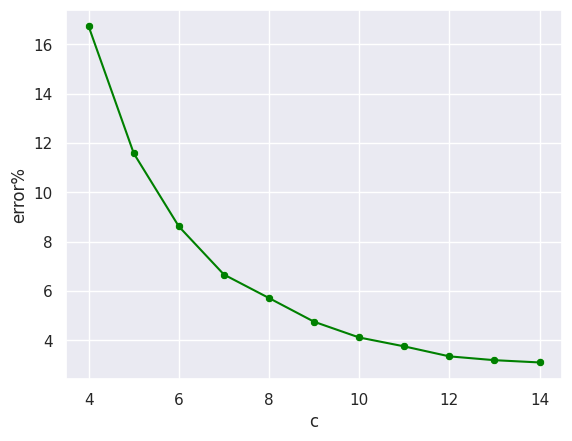

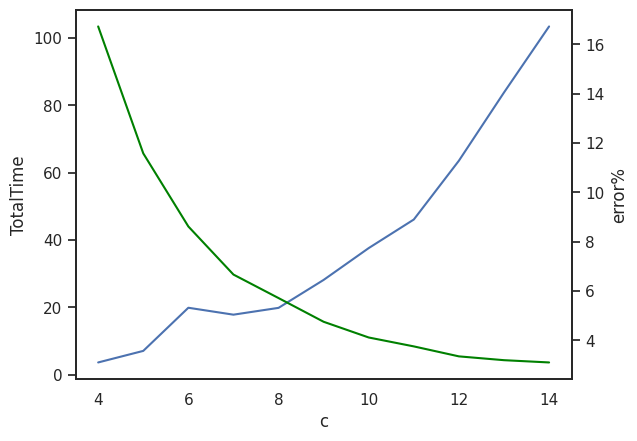

<Axes: xlabel='c', ylabel='Num Elements'>

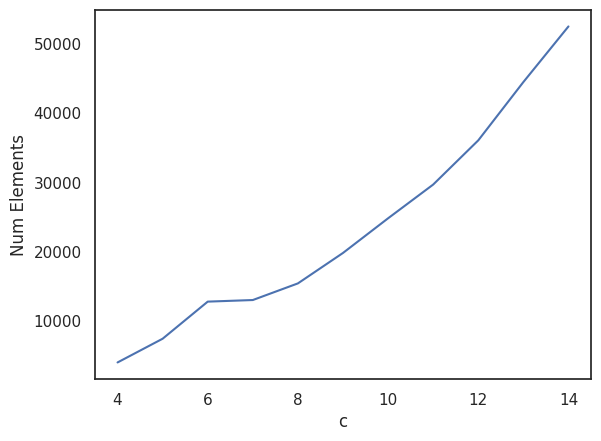

In [114]:
# plt.plot(res["c"],res["Num Nodes"],marker='.',color='green')
# plt.title("Target number of elements per rotation vs number of nodes")
# plt.xlabel("Target number of nodes per rotation")
# plt.ylabel("Number of nodes")
# plt.show()

# plt.plot(res['c'],res["error%"])
# plt.show()
sns.set_theme()
sns.set_palette("bright")

sns.lineplot(
    data=res,
    x="c",y="error%",
    color="green"
)

sns.scatterplot(
    data=res,
    x="c",y="error%",
    color="green"
)

plt.show()

sns.set_theme(style="white")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

sns.lineplot(data=res, x ='c', y='TotalTime',ax=ax1)
sns.lineplot(data=res, x ='c', y="error%",color="green",ax=ax2)
plt.show()


In [119]:
SPIN_DENS = 5e17
MU_B = 9.2740100783e-24
PHI_0 = 2.067833848e-15
MU_0 = 1.25663706212e-6 	
Analytic = lambda R, D : 2/3*MU_0**2*MU_B**2*SPIN_DENS*R/D*1/(PHI_0**2)
r1 = 15e-6
r2 = 0.2e-6

Analytic(r1,2*r2)

3.9703938427462754e-10